In [24]:
# Downloading the dataset
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet -P /workspaces/mlops-learning/01-intro/data
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet -P /workspaces/mlops-learning/01-intro/data


# Download 2021 data
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet -P /workspaces/mlops-learning/01-intro/data

--2024-08-29 16:26:34--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.164.82.112, 3.164.82.197, 3.164.82.40, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.164.82.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21686067 (21M) [application/x-www-form-urlencoded]
Saving to: ‘/workspaces/mlops-learning/01-intro/data/yellow_tripdata_2021-01.parquet’

yellow_tripdata_202 100%[===================>]  20.68M  15.5MB/s    in 1.3s    

2024-08-29 16:26:35 (15.5 MB/s) - ‘/workspaces/mlops-learning/01-intro/data/yellow_tripdata_2021-01.parquet’ saved [21686067/21686067]



In [23]:
# importing all the necesasry libraries

import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import root_mean_squared_error


from sklearn.model_selection import cross_val_score, KFold

In [8]:
# load the data

data = pd.read_parquet("/workspaces/mlops-learning/01-intro/data/yellow_tripdata_2024-01.parquet")
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [9]:
# checking the dtypes
data.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [10]:
# our Goal is, given some features, we need to predict the ride time.
# For each record in the dataset, we can get the ride time by subtracting tpep_dropoff_datetime - tpep_pickup_datetime, 
# as these are the pickup and drop off time, from these columns, we can get ride duration

data['ride_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'] # this will be of format "0 days 00:19:48"
data['ride_duration'] = data['ride_duration'].apply(lambda x: x.seconds/60) # as its a datetime object, we can get the seconds 
# we divide the seconds by 60, so that the "ride_duration" is in minutes
data['ride_duration']

0          19.800000
1           6.600000
2          17.916667
3           8.300000
4           6.100000
             ...    
2964619     8.616667
2964620    14.750000
2964621    19.000000
2964622    17.850000
2964623    15.083333
Name: ride_duration, Length: 2964624, dtype: float64

In [11]:
# Let's observe the ride duration data
data.ride_duration.describe(percentiles=[0.95, 0.97, 0.99])

count    2.964624e+06
mean     1.562849e+01
std      3.460262e+01
min      0.000000e+00
50%      1.163333e+01
95%      3.795000e+01
97%      4.526667e+01
99%      6.046667e+01
max      1.439983e+03
Name: ride_duration, dtype: float64

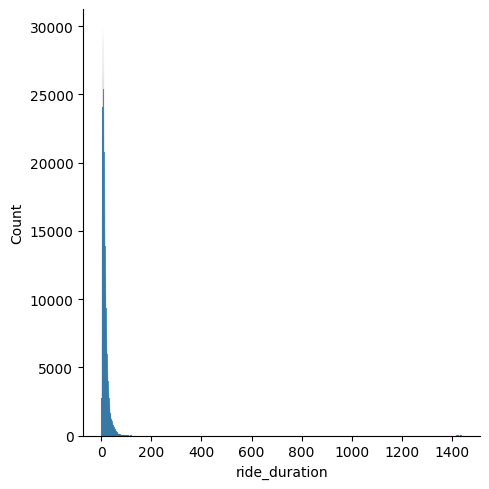

In [12]:
sns.displot(data.ride_duration)

We can see that almost 99% of the data has a ride duration of 1 hour

In [13]:
# len(data[(data['ride_duration'] > 0) & (data['ride_duration'] < 60)]) # 2933100
data = data[(data['ride_duration'] > 1) & (data['ride_duration'] < 60)]

# take only 70k rows - as whole data might take too long for training
train_data = data.sample(n = 70000)
train_data.shape

(70000, 20)

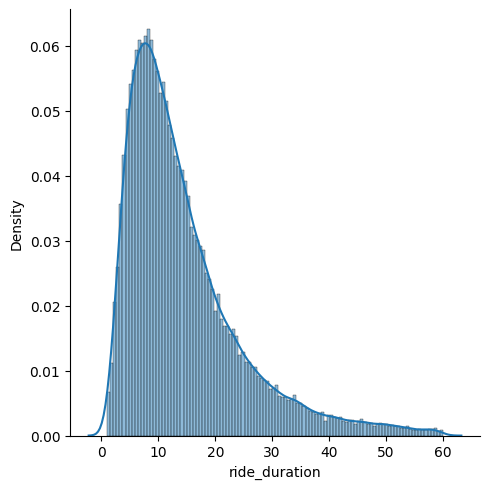

In [14]:
# any of the below can be used
# sns.displot(train_data.ride_duration, kde=True) # kde will add the curve
sns.displot(train_data.ride_duration, kde=True, stat='density',kde_kws=dict(cut=3)) # kde_kws=dict(cut=3) will extend the curve to fall on x axis, to check, once remove this and try

In [15]:
# lets take a look  at the features
train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,ride_duration
2922457,2,2024-01-21 20:55:27,2024-01-21 21:10:53,NaN,3.00,NaN,None,142,170,0,9.18,0.0,0.5,2.32,0.0,1.0,15.50,NaN,NaN,15.433333
716020,2,2024-01-09 17:23:11,2024-01-09 17:34:53,2.0,1.41,1.0,N,161,237,1,12.10,2.5,0.5,1.86,0.0,1.0,20.46,2.5,0.0,11.700000
626044,2,2024-01-08 16:22:30,2024-01-08 16:29:58,2.0,1.30,1.0,N,237,170,1,9.30,2.5,0.5,3.16,0.0,1.0,18.96,2.5,0.0,7.466667
2892344,2,2024-01-17 08:05:35,2024-01-17 08:34:43,NaN,3.13,NaN,None,237,246,0,33.34,0.0,0.5,0.00,0.0,1.0,37.34,NaN,NaN,29.133333
1657994,2,2024-01-19 18:39:42,2024-01-19 18:56:40,1.0,2.51,1.0,N,161,224,1,16.30,2.5,0.5,4.00,0.0,1.0,26.80,2.5,0.0,16.966667


For, now lets take PULocationID(a unique pickup location ID) and DOLocationID(a unique Drop Location ID) as features and predict ride duration

Now, the PULocationID and DOLocationID are both categorical variables (even though they are numbers, they're not continous and discrete, hence they are categorical)

As both features have many categories, we will perform a onehotencoding OHE on them. For this we will use DictVectorizer(), but by default, DictVectorizer() only process categories that are strings and do no process numerical data and just returns it as it is. So for this, we will begin by converting both columns to strings

In [16]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['ride_duration']

train_data[categorical] = train_data[categorical].astype(str)
train_data = train_data[categorical + numerical]

train_data.to_dict(orient='records')

[{'PULocationID': '142',
  'DOLocationID': '170',
  'ride_duration': 15.433333333333334},
 {'PULocationID': '161', 'DOLocationID': '237', 'ride_duration': 11.7},
 {'PULocationID': '237',
  'DOLocationID': '170',
  'ride_duration': 7.466666666666667},
 {'PULocationID': '237',
  'DOLocationID': '246',
  'ride_duration': 29.133333333333333},
 {'PULocationID': '161',
  'DOLocationID': '224',
  'ride_duration': 16.966666666666665},
 {'PULocationID': '262', 'DOLocationID': '138', 'ride_duration': 16.15},
 {'PULocationID': '236',
  'DOLocationID': '263',
  'ride_duration': 2.933333333333333},
 {'PULocationID': '114',
  'DOLocationID': '97',
  'ride_duration': 16.333333333333332},
 {'PULocationID': '90',
  'DOLocationID': '249',
  'ride_duration': 12.083333333333334},
 {'PULocationID': '237',
  'DOLocationID': '263',
  'ride_duration': 5.383333333333334},
 {'PULocationID': '70',
  'DOLocationID': '138',
  'ride_duration': 5.233333333333333},
 {'PULocationID': '138', 'DOLocationID': '231', 'rid

In [17]:
# to use the DictVectorizer, we need to convert the dataframe to dict

train_dicts = train_data.to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210000 stored elements and shape (70000, 459)>

In [12]:
# a function to read the data, preprocess it and return it
def read_and_preprocess(filename):
    data = pd.read_parquet(filename)
    
    # create the target variable
    data['ride_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'] 
    data['ride_duration'] = data['ride_duration'].apply(lambda x: x.total_seconds()/60) 

    # take only the data below 1 hour
    data = data[(data['ride_duration'] >= 1) & (data['ride_duration'] <= 60)]

    # sample the data to 70k rows
    sampled_data = data.iloc[:70000,:].copy()
    
    # chosing categorical
    categorical = ['PULocationID', 'DOLocationID']

    # convert these numerical categorical features to string categorical features
    sampled_data[categorical] = sampled_data[categorical].astype(str)


    return sampled_data



In [13]:
sampled_data = read_and_preprocess('/workspaces/mlops-learning/01-intro/data/yellow_tripdata_2024-01.parquet')

In [14]:
# chosing categorical and numerical features
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# creating the training data with the features
train_data = sampled_data[categorical + numerical]

# storing our target variable
target = 'ride_duration'
y_train = sampled_data[target].values

In [15]:
# to use the DictVectorizer, we need to convert the dataframe to dict
train_dicts = train_data.to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210000 stored elements and shape (70000, 447)>

In [16]:
# train a LinearRegression Model

lr = LinearRegression()

lr.fit(X_train, y_train)

# make predictions on train data
y_pred = lr.predict(X_train)

# calculate the metrics
root_mean_squared_error(y_train, y_pred) # squared set to False implies we are using RMSE instead MSE

np.float64(5.797042749628479)

/tmp/ipykernel_38983/2618114705.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, kde=True, label='Actual')
/tmp/ipykernel_38983/2618114705.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, kde=True, label='Predicted')


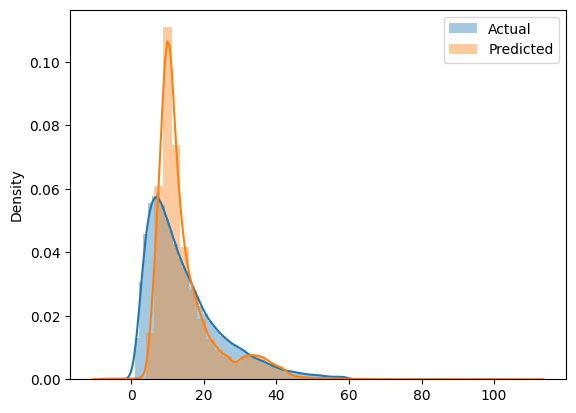

In [20]:
# sns.displot(y_train, kde=True, stat='density',kde_kws=dict(cut=3), label='Actual')
# sns.displot(y_pred, kde=True, stat='density',kde_kws=dict(cut=3), label='Predicted') 

sns.distplot(y_train, kde=True, label='Actual')
sns.distplot(y_pred, kde=True, label='Predicted') 

# sns.kdeplot(y_train,label='Actual')
# sns.kdeplot(y_pred,label='Predicted') 

plt.legend()


### Plotting Residuals

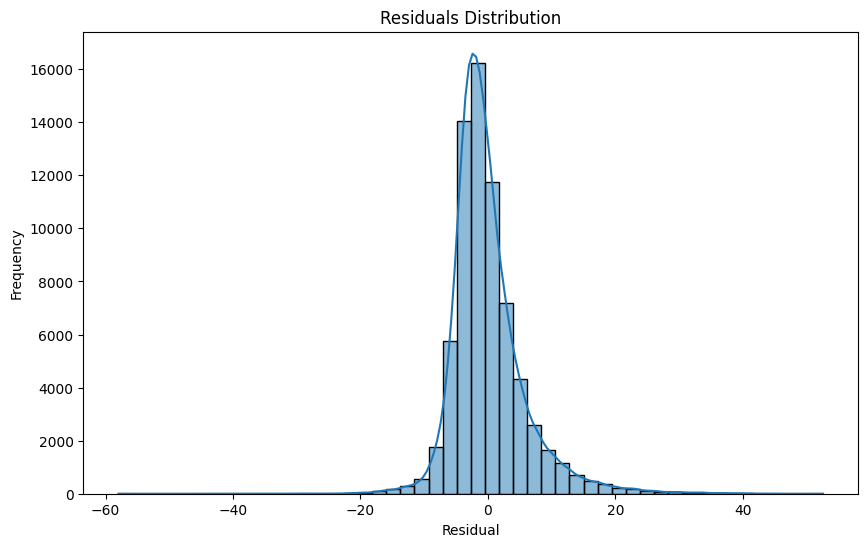

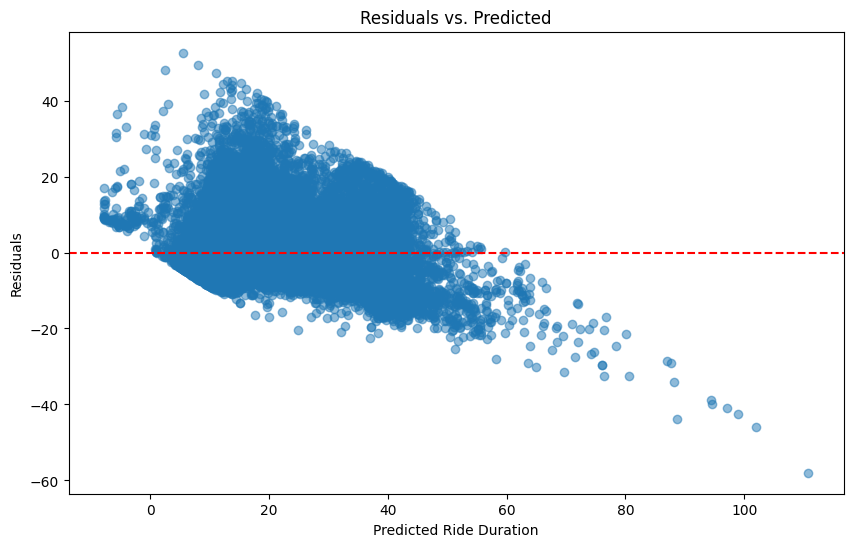

In [22]:
# Calculate residuals for the validation set
residuals = y_train - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted Ride Duration")
plt.ylabel("Residuals")
plt.show()


### K-Fold Cross Valiation

In [24]:
# Convert the dataset to dictionaries
train_dicts = train_data.to_dict(orient='records')

# Vectorize the data
dv = DictVectorizer()
X = dv.fit_transform(train_dicts)
y = sampled_data['ride_duration'].values

# Initialize the Linear Regression model
lr = LinearRegression()

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_rmse = np.sqrt(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error'))

print(f'Cross-Validation RMSE: {cv_rmse}')
print(f'Average Cross-Validation RMSE: {cv_rmse.mean()}')

Cross-Validation RMSE: [5.87214604 5.94142789 5.96554232 5.80563044 5.80900893]
Average Cross-Validation RMSE: 5.87875112379174


`scoring='neg_mean_squared_error'`: This tells cross_val_score to evaluate the model using the Negative Mean Squared Error (MSE) as the scoring metric. The reason for using "negative" MSE is that cross_val_score by default assumes higher scores are better, so negative values allow it to maintain consistency (since MSE is a loss function, lower is better).

`-cross_val_score(...):`

The scores returned by cross_val_score are negative because of the `neg_mean_squared_error` scoring. By negating them (multiplying by -1), you get the actual Mean Squared Error (MSE) values for each fold. If it's negative we cannot take the square root of it

MSE is the average of the squared differences between the predicted and actual values. RMSE is the square root of the MSE, which is more interpretable because it’s in the same units as the target variable (ride_duration in this case).


In [26]:
# Perform cross-validation - Without Scoring Variable
# if scoring is not mentioned, the default score func of estimator will be used
# the default scorer for LinearReg is R Square i.e. (1 - u/v), where
# "u" is he residual sum of squares ((y_true - y_pred)** 2).sum() and is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()
# and the best possible score is 1.0 and worst is 0
cv_rmse = np.sqrt(cross_val_score(lr, X, y, cv=kf))

print(f'Cross-Validation RMSE: {cv_rmse}')
print(f'Average Cross-Validation RMSE: {cv_rmse.mean()}')

Cross-Validation RMSE: [0.82801636 0.81976742 0.82515868 0.82878804 0.83299871]
Average Cross-Validation RMSE: 0.826945840395376
